In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [3]:
# Load the dataset
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

# Display the first few rows of the dataset
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [13]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [6]:
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True,stratify=y, test_size=0.3, random_state=42)

In [28]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [29]:
y_train_smote.value_counts()

1    350
0    350
Name: Outcome, dtype: int64

In [8]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Create and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [10]:
# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.71


In [11]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[125  25]
 [ 41  40]]


In [12]:
# Classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       150
           1       0.62      0.49      0.55        81

    accuracy                           0.71       231
   macro avg       0.68      0.66      0.67       231
weighted avg       0.70      0.71      0.71       231



# Grid search on KNN

In [16]:
# Define the model
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 31)}

# Set up GridSearchCV with ROC AUC as the scoring metric
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 31)}, scoring='roc_auc')

In [18]:
# Get the best parameter and the best score
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"Best K: {best_k}")
print(f"Best Cross-Validation ROC AUC: {best_score:.2f}")

Best K: 30
Best Cross-Validation ROC AUC: 0.81


In [19]:
# Train the model with the best K
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_knn.predict(X_test)
y_pred_prob = best_knn.predict_proba(X_test)[:, 1]

In [26]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.73


In [20]:
# Evaluate the model using ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC on Test Set: {roc_auc:.2f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

ROC AUC on Test Set: 0.81


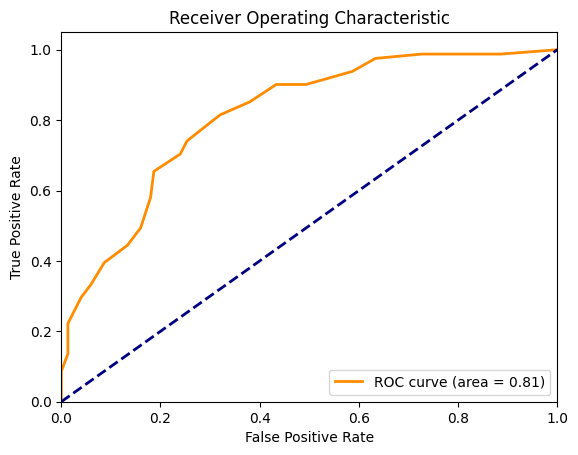

In [23]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[137  13]
 [ 49  32]]


In [25]:
# Classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       150
           1       0.71      0.40      0.51        81

    accuracy                           0.73       231
   macro avg       0.72      0.65      0.66       231
weighted avg       0.73      0.73      0.71       231



# SMOTE oversampling

In [30]:
# Define the model
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 31)}

# Set up GridSearchCV with ROC AUC as the scoring metric
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameter and the best score
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Best K: {best_k}")
print(f"Best Cross-Validation ROC AUC: {best_score:.2f}")

Best K: 3
Best Cross-Validation ROC AUC: 0.86


In [46]:
# Train the model with the best K
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = best_knn.predict(X_test)
y_pred_prob = best_knn.predict_proba(X_test)[:, 1]


ROC AUC on Test Set: 0.76


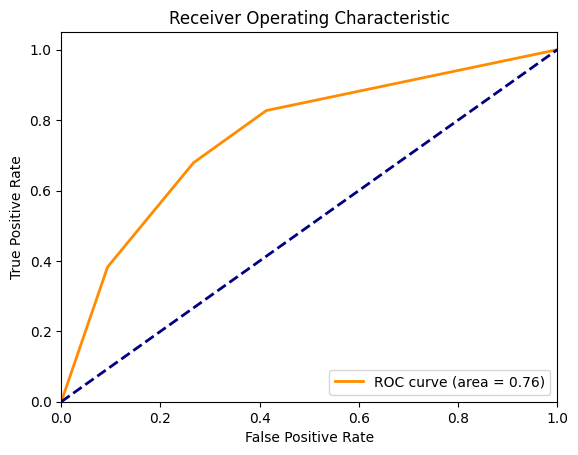

In [32]:
# Evaluate the model using ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC on Test Set: {roc_auc:.2f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [34]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[110  40]
 [ 26  55]]


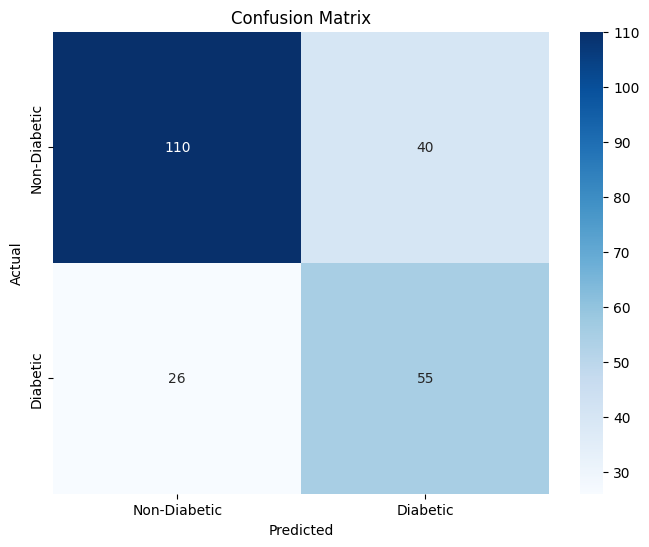

In [37]:
# Plot confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       150
           1       0.58      0.68      0.62        81

    accuracy                           0.71       231
   macro avg       0.69      0.71      0.70       231
weighted avg       0.73      0.71      0.72       231



# Another try to improve accuracy

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Load the dataset
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

# Display the first few rows of the dataset
print(df.head())

# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [47]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


SelectKBest:

    1- SelectKBest is a feature selection method from the sklearn.feature_selection module. 

    2- It selects the top k features based on their scores. 

    3- The scores can be computed using different statistical tests. 

    4- This method helps in reducing the dimensionality of the dataset by selecting only the most relevant features, which can improve the performance of machine learning models by eliminating noise and redundant data.

f_classif:

    1- f_classif is a scoring function used with SelectKBest for performing ANOVA (Analysis of Variance) F-test for classification tasks. 

    2- It evaluates each feature individually by comparing the means of different classes and checking if they are significantly different. 

    3- Higher F-scores indicate that the feature has a strong relationship with the target variable.

How SelectKBest and f_classif work together:

    1- Compute F-scores: For each feature, the f_classif function computes an F-score and a corresponding p-value. 

    2- The F-score measures the degree of linear dependency between the feature and the target variable.

    3- Select Top Features: SelectKBest selects the top k features with the highest F-scores.

In [49]:
from sklearn.feature_selection import SelectKBest, f_classif

# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=5)
selector = selector.fit(X_train_smote, y_train_smote)
X_train_smote_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test)

In [50]:
# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Set up GridSearchCV with ROC AUC as the scoring metric
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train_smote_selected, y_train_smote)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(algorithm='brute'),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [51]:
# Get the best parameter and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation ROC AUC: {best_score:.2f}")

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
Best Cross-Validation ROC AUC: 0.90


In [52]:
# Train the model with the best parameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train_smote_selected, y_train_smote)

KNeighborsClassifier(metric='manhattan', n_neighbors=17, weights='distance')

In [53]:
# Make predictions on the test set
y_pred = best_knn.predict(X_test_selected)
y_pred_prob = best_knn.predict_proba(X_test_selected)[:, 1]

ROC AUC on Test Set: 0.79


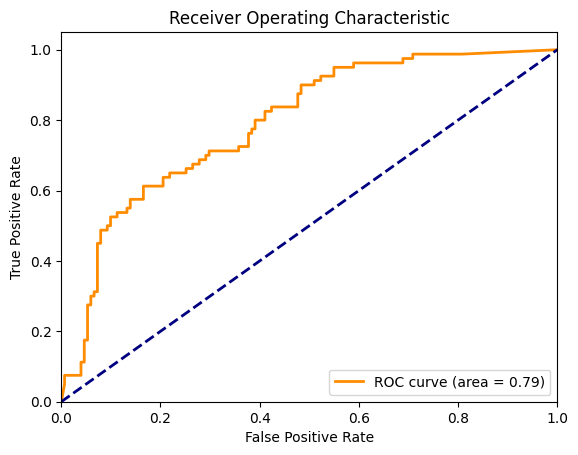

In [54]:
# Evaluate the model using ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC on Test Set: {roc_auc:.2f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix:
[[101  50]
 [ 23  57]]


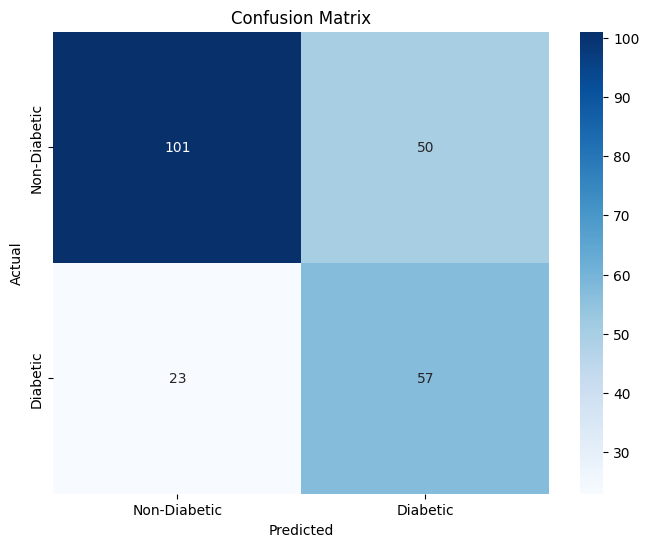

In [55]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [56]:
# Classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       151
           1       0.53      0.71      0.61        80

    accuracy                           0.68       231
   macro avg       0.67      0.69      0.67       231
weighted avg       0.72      0.68      0.69       231



# Another try to apply different distance metrics

In [57]:
# Load the dataset
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [58]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [59]:
# Feature selection using SelectKBest and f_classif
selector = SelectKBest(f_classif, k=5)
X_train_smote_selected = selector.fit_transform(X_train_smote, y_train_smote)
X_test_selected = selector.transform(X_test)

In [65]:
# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev' , 'hamming'],
    'p': [1, 2]  # Parameter for Minkowski distance, p=1 is Manhattan, p=2 is Euclidean
}

# Set up GridSearchCV with accuracy as the scoring metric
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_smote_selected, y_train_smote)

# Get the best parameter and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.83


In [66]:
# Train the model with the best parameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train_smote_selected, y_train_smote)

# Make predictions on the test set
y_pred = best_knn.predict(X_test_selected)
y_pred_prob = best_knn.predict_proba(X_test_selected)[:, 1]

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy:.2f}')

# Evaluate the model using ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC on Test Set: {roc_auc:.2f}')

Accuracy on Test Set: 0.68
ROC AUC on Test Set: 0.74


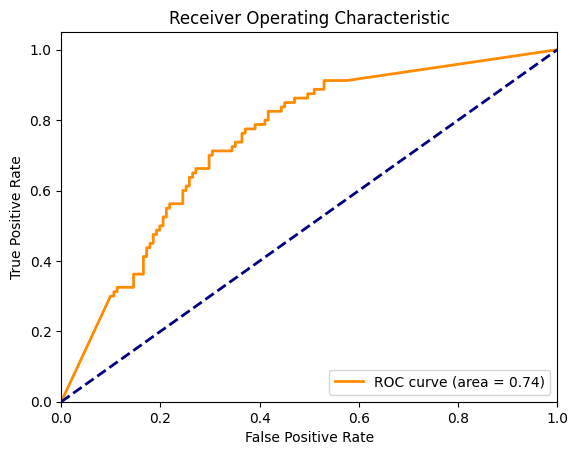

In [67]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Confusion Matrix:
[[99 52]
 [23 57]]


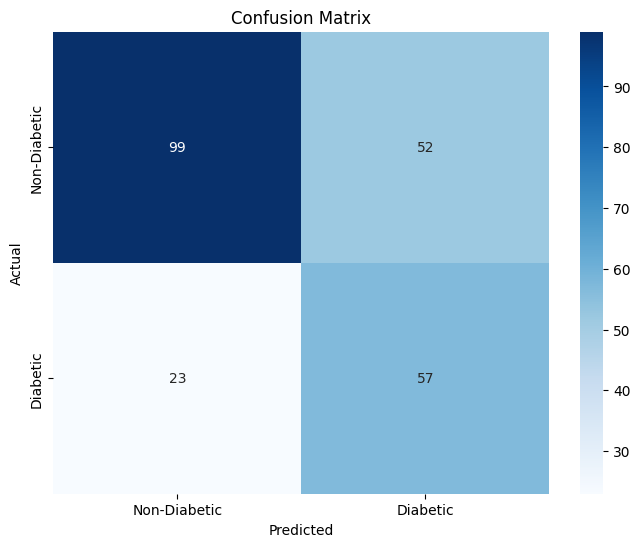

In [68]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [69]:
# Classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.66      0.73       151
           1       0.52      0.71      0.60        80

    accuracy                           0.68       231
   macro avg       0.67      0.68      0.66       231
weighted avg       0.71      0.68      0.68       231



# multi classification on iris dataset

In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# Load the Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [72]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [73]:
# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Parameter for Minkowski distance, p=1 is Manhattan, p=2 is Euclidean
}

# Set up GridSearchCV with accuracy as the scoring metric
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameter and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.94


In [74]:
# Train the model with the best parameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_knn.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy:.2f}')

Accuracy on Test Set: 1.00


Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


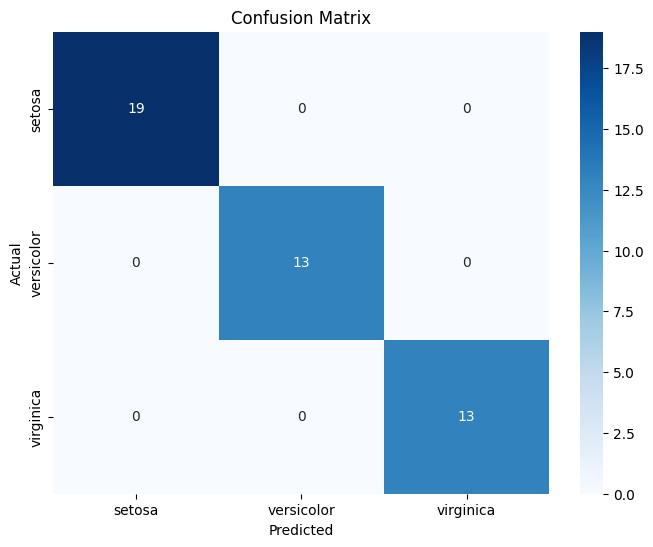

In [75]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [76]:
# Classification report
class_report = classification_report(y_test, y_pred, target_names=iris.target_names)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



# KNN as regression

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
# Load the Boston Housing dataset
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

In [80]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [85]:
# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Parameter for Minkowski distance, p=1 is Manhattan, p=2 is Euclidean
}

# Set up GridSearchCV with negative MSE as the scoring metric
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=10, scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameter and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best r2_score: {best_score:.2f}")

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Best r2_score: -0.73


In [86]:
# Train the model with the best parameters
best_knn = KNeighborsRegressor(**best_params)
best_knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_knn.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 0.36
Mean Absolute Error: 0.40
R-squared: 0.73


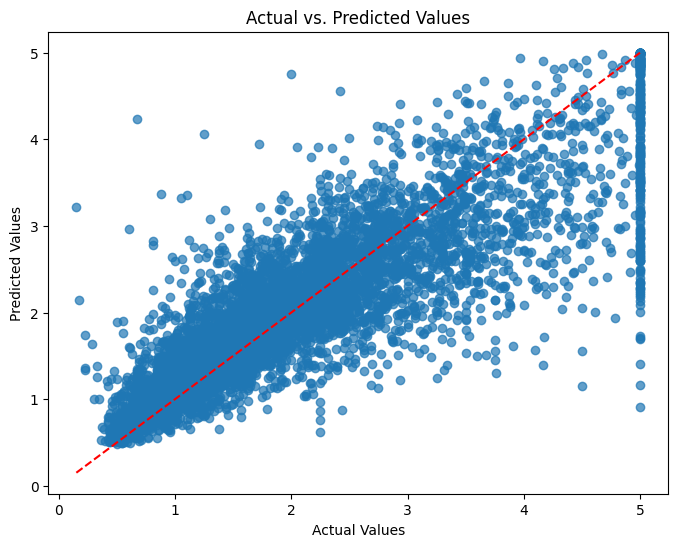

In [87]:
# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

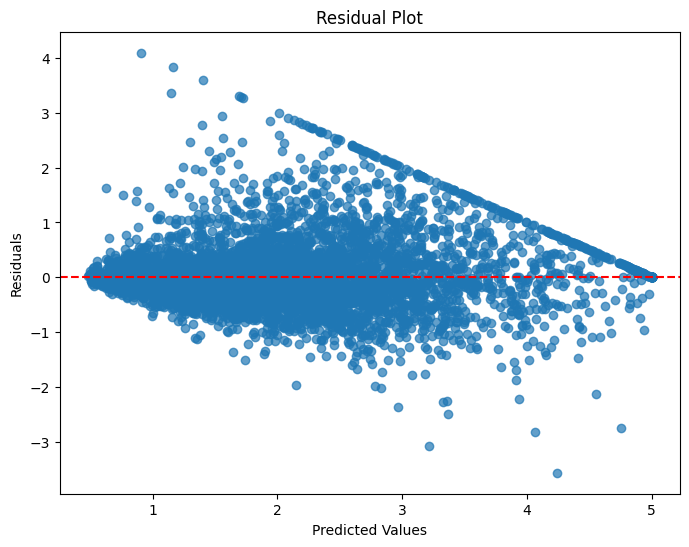

In [88]:
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()